In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import torch.nn.functional as F
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import Dataset
import os
from PIL import Image
import sklearn
import sklearn.metrics as sklm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
"""
Uses GPU if GPU is available 

Args:
    None
Returns:
    None
"""
if torch.cuda.is_available():

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [3]:
"""
Set mean and standard deviation of Imagenet images 
Set Batch Size
"""
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
BATCH_SIZE = 32

In [4]:
"""
define data transforms for images for train and validation dataset
"""
data_transforms = {
        'train': transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),
        'val': transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),
    }

In [5]:
class CustomDataset(Dataset):
    """
    define CustomDataset for  chestXray Images 
    """

    def __init__(self,path_to_images,labelcsv,transform=None):
 
        """
        Args:
        path_to_images: location of images
        labelcsv: labels for images 
        transform: 
        Returns:
        None
        """

        self.transform = transform
        self.path_to_images = path_to_images
        self.df = pd.read_csv(labelcsv)

        self.df = self.df.set_index("Image Index")
        self.PRED_LABEL = [
            'Atelectasis',
            'Cardiomegaly',
            'Effusion',
            'Infiltration',
            'Mass',
            'Nodule',
            'Pneumonia',
            'Pneumothorax',
            'Consolidation',
            'Edema',
            'Emphysema',
            'Fibrosis',
            'Pleural_Thickening',
            'Hernia']

        RESULT_PATH = "results/"

    def __len__(self):
        """
        Args: None
        Returns : Length of dataset
        """
        return len(self.df)

    def __getitem__(self, idx):
        """
        Args: index of the image in dataset
        Returns : image and label for training and validation
        """

        image = Image.open(
            os.path.join(
                self.path_to_images,
                self.df.index[idx]))
        image = image.convert('RGB')

        label = np.zeros(len(self.PRED_LABEL), dtype=int)
        for i in range(0, len(self.PRED_LABEL)):
            if(self.df[self.PRED_LABEL[i].strip()].iloc[idx].astype('int') > 0):
                label[i] = self.df[self.PRED_LABEL[i].strip()
                                   ].iloc[idx].astype('int')

        if self.transform:
            image = self.transform(image)

        return (image, label,self.df.index[idx])
    
    

In [6]:
def load_data(data_path='/home/ubuntu/payload/NIHData/images/'):
    """
    Creates train and validation dataset
    Args: None
    Returns: train and validation loader and data
    """

    data_train = CustomDataset(
        path_to_images=data_path,
        labelcsv = 'train_0.1.csv',
        transform=data_transforms['train'])
    data_val = CustomDataset(
        path_to_images=data_path,
        labelcsv = 'val-small_0.1.csv',
        transform=data_transforms['val'])

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = torch.utils.data.DataLoader(data_val, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, val_loader , data_train , data_val

In [17]:
def get_cnn_model():

    """
        Defines the CNN model here. Used ResNet50 pretrained model
        replaced the last layer (model.fc) with a nn.Linear layer and sigmoid
        update weights in all the layers as the model is trained on different data ( not chestXray)
    """

    from torchvision import models

    num_classes = 14

    model = models.resnet50(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, num_classes), nn.Sigmoid())

    return model

In [18]:
'''
Create the model , move model to GPU
Use Binary Cross Entropy (BCE)as loss function - out put of our model will be 14 probabilities for 14 labels,
  we need to use BCE as loss the output of our model
we will do 10 epochs
We will use SDG with momentum as Optimizer
'''
model = get_cnn_model()
model.cuda()
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
LR = 0.01
optimizer = torch.optim.SGD(
        filter(
            lambda p: p.requires_grad,
            model.parameters()),
        lr=LR,
        momentum=0.9,
        weight_decay=1e-4)

In [19]:
n_epochs = 10
def train_model(model, train_dataloader, val_dataloader, n_epoch=n_epochs, optimizer=optimizer, criterion=criterion):
    import torch.optim as optim
    """
    
    Args:
    model: A CNN model
    train_dataloader: the DataLoader of the training data
    n_epoch: number of epochs to train
    optimizer: optimizer for training
    criterion: Loss function
    Return:
        model: trained model 
    
    """
    
    train_epochs_loss = pd.DataFrame(columns=["Epoch No","Loss"])
    val_epochs_loss = pd.DataFrame(columns=["Epoch No","Loss"])   
    
    for epoch in range(n_epoch):
        
        model.train()
        train_row={}
        train_curr_epoch_loss = []
        for data in train_dataloader:
            inputs = data[0].to(device)
            labels = data[1].to(device)            
            optimizer.zero_grad()
            y_hat = model(inputs)
            y_hat = y_hat.to(device)
            labels = labels.type(torch.FloatTensor)
            labels = labels.to(device)
            loss = criterion(y_hat, labels)
            loss.backward()
            optimizer.step()

            train_curr_epoch_loss.append(loss.cpu().data.numpy())
            
        train_row["Epoch No"] = epoch
        train_row["Loss"] = np.mean(train_curr_epoch_loss)
        train_epochs_loss = train_epochs_loss.append(train_row,ignore_index=True)
        print(f"Epoch {epoch}: Train curr_epoch_loss={np.mean(train_curr_epoch_loss)}")
        
        model.eval()

        val_row={}
        
        val_curr_epoch_loss = []
        for i, data in enumerate(val_dataloader):    
            
            inputs = data[0].to(device)
            labels = data[1].to(device)            
            labels = labels.type(torch.FloatTensor)
            labels = labels.to(device)
            true_labels = labels.cpu().data.numpy()            
            y_hat = model(inputs)
            y_hat = y_hat.to(device)
            probs = y_hat.cpu().data.numpy()                            
            loss = criterion(y_hat, labels)
            val_curr_epoch_loss.append(loss.cpu().data.numpy())

        val_row["Epoch No"] = epoch
        val_row["Loss"] = np.mean(val_curr_epoch_loss)
        val_epochs_loss = val_epochs_loss.append(val_row,ignore_index=True)
        print(f"Epoch {epoch}: Val curr_epoch_loss={np.mean(val_curr_epoch_loss)}")
        
    return model,train_epochs_loss,val_epochs_loss

In [ ]:
train_loader, val_loader , train_dataset , val_dataset = load_data()
model,train_epochs_loss,val_epochs_loss = train_model(model, train_loader,val_loader)

Epoch 0: Train curr_epoch_loss=0.1632981300354004
Epoch 0: Val curr_epoch_loss=0.15257905423641205
Curr Val loss less than best Val loss , LR :  0.01
Epoch 1: Train curr_epoch_loss=0.15124818682670593
Epoch 1: Val curr_epoch_loss=0.1479988694190979
Curr Val loss less than best Val loss , LR :  0.01
Epoch 2: Train curr_epoch_loss=0.14613911509513855
Epoch 2: Val curr_epoch_loss=0.14781911671161652
Curr Val loss less than best Val loss , LR :  0.01
Epoch 3: Train curr_epoch_loss=0.141935333609581
Epoch 3: Val curr_epoch_loss=0.14748385548591614
Curr Val loss less than best Val loss , LR :  0.01
Epoch 4: Train curr_epoch_loss=0.13797374069690704


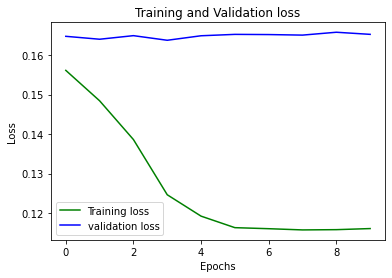

In [15]:
"""
Plot Training and Validation Loss
"""
loss_train = train_epochs_loss['Loss']
loss_val = val_epochs_loss['Loss']
epochs = val_epochs_loss['Epoch No']
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
def eval_model(model, dataloader):
    """
    Use the trained/best model and valuate on validation dataset
    Args:
    model: trained model
    dataloader: validation dataloader
    :return:
        Y_pred: prediction of model on the dataloder.
        Y_test: truth labels. 
    """
    model.eval()

    pred_df = pd.DataFrame(columns=["Image Index"])
    true_df = pd.DataFrame(columns=["Image Index"])
    for i, data in enumerate(dataloader):
        inputs = data[0].to(device)
        labels = data[1].to(device)
        true_labels = labels.cpu().data.numpy()
        batch_size = true_labels.shape
        y_hat = model(inputs)
        probs = y_hat.cpu().data.numpy()

        for j in range(0, batch_size[0]):
            thisrow = {}
            truerow = {}
            thisrow["Image Index"] = val_dataset.df.index[BATCH_SIZE * i + j]
            truerow["Image Index"] = val_dataset.df.index[BATCH_SIZE * i + j]


            for k in range(len(val_dataset.PRED_LABEL)):
                thisrow["prob_" + val_dataset.PRED_LABEL[k]] = probs[j, k]
                truerow[val_dataset.PRED_LABEL[k]] = true_labels[j, k]

            pred_df = pred_df.append(thisrow, ignore_index=True)
            true_df = true_df.append(truerow, ignore_index=True)

        if(i % 10 == 0):
            print(str(i * BATCH_SIZE))


    return pred_df, true_df

In [17]:
"""
Evaluate the Model
"""
pred_df, true_df = eval_model(model, val_loader)

0
320
640
960
1280
1600
1920
2240


In [18]:
"""
Get Prediction and True values for Validation dataset and generate AUC Vaules for Validation dataset
"""
auc_df = pd.DataFrame(columns=["label", "auc"])

for column in true_df:

    if column not in [
            'Atelectasis',
            'Cardiomegaly',
            'Effusion',
            'Infiltration',
            'Mass',
            'Nodule',
            'Pneumonia',
            'Pneumothorax',
            'Consolidation',
            'Edema',
            'Emphysema',
            'Fibrosis',
            'Pleural_Thickening',
                'Hernia']:
        continue
    actual = true_df[column]
    pred = pred_df["prob_" + column]
    thisrow = {}
    thisrow['label'] = column
    thisrow['auc'] = np.nan
    try:
        thisrow['auc'] = sklm.roc_auc_score(
        actual.values.astype(int), pred.values)

        
    except BaseException as e:
        print("can't calculate auc for " + str(column))
        print(e)
    auc_df = auc_df.append(thisrow, ignore_index=True)

pred_df.to_csv("ResNetSGDMom/ResNetpreds.csv", index=False)
auc_df.to_csv("ResNetSGDMom/ResNetaucs.csv", index=False)